# Vegetable Image Classifier

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Functions

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_and_preprocess_image(image_path, target_size=(250, 250)):
    try:
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            img = img.convert('RGB')

            img_array = np.array(img) / 255.0
            img_array = img_array.astype(np.float32)
        return img_array
    except IOError as e:

        print(f"Error loading image {image_path}: {e}")
        return None

def grab_images(directory):
    X = []
    y = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                img = load_and_preprocess_image(file_path)
                if img is not None:
                    X.append(img)
                    label = root.split(os.sep)[-1]
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

def create_model():
    model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(), 
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    model.summary()

# Main Paths

In [3]:
PATH = "/Users/maukanmir/Downloads/Images/"
train_path, test_path, val_path = PATH + "train/", PATH + "test/", PATH + "validation/"

# Read in training data

In [9]:
X_train, y_train = grab_images(train_path)
X_test, y_test = grab_images(test_path)
X_val, y_val = grab_images(val_path)

# EDA Analysis

# Check Class Imbalance

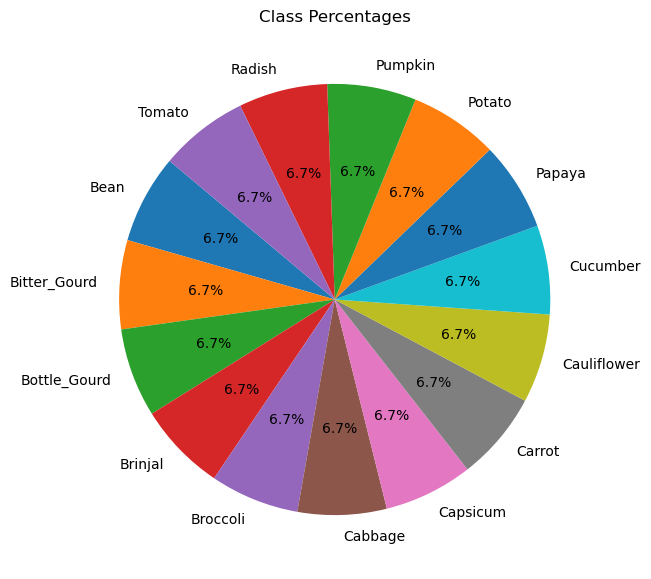

In [11]:
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(10, 7))
plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
plt.title("Class Percentages")
plt.show()

# We have a balanced dataset